In [1]:
%matplotlib inline
import numpy as np
from nicks_plot_utils import TH1D, TH2D
from lmfit import CompositeModel, Model
import matplotlib.pyplot as plt
import pandas as pd
import ROOT
from lmfit.models import *
from scipy.special import erf, wofz


Welcome to JupyROOT 6.26/02


In [2]:
mu = 2.0
sigma = 0.2
num = 100_000

data = pd.DataFrame({'W' : np.random.gumbel(mu, sigma, num),
                     'y' : np.random.normal(mu, sigma+0.1, num),
                     'z' : np.random.normal(mu, sigma, num)})

In [3]:
# Wrapper around ROOT TH1 with some nice features
exRoot = TH1D("exRoot","Example of a ROOT Histogram", 250, 0., 5.)

In [4]:
%%time
# fill a ROOT histogram with an array
exRoot.fill(data.W)
# exRoot.fill(data.z)

CPU times: user 5.05 ms, sys: 467 µs, total: 5.51 ms
Wall time: 5.28 ms


In [5]:
c1 = ROOT.TCanvas("c","c",800,450)

class SkewedVoigt:
    def __call__(self, x, par):
        """Return a Voigt lineshape, skewed with error function.
        Equal to: voigt(x, center, sigma, gamma)*(1+erf(beta*(x-center)))
        where ``beta = skew/(sigma*sqrt(2))``
        with ``skew < 0``: tail to low value of centroid
             ``skew > 0``: tail to high value of centroid
        Useful, for example, for ad-hoc Compton scatter profile. For more
        information, see: https://en.wikipedia.org/wiki/Skew_normal_distribution
        """
        x=x[0]
        amplitude=par[0]
        center=par[1]
        sigma=par[2]
        gamma=par[3]
        skew=par[4]
        
        beta = skew/max(tiny, (np.sqrt(2.0)*sigma))
        asym = 1 + erf(beta*(x-center))
        if gamma is None:
            gamma = sigma
            
        z = (x-center + 1j*gamma) / max(tiny, (sigma*np.sqrt(2.0)))
        voigt = amplitude*wofz(z).real / max(tiny, (sigma*np.sqrt(2.0*np.pi)))
        
        return asym * voigt


pycallable = SkewedVoigt()
f = ROOT.TF1("SkewedVoigt",pycallable, 0, 5, 5)

f.SetParNames('amplitude','center','sigma','skew', 'gamma')
f.SetParameters(2253, 1.8, 0.17, 0.17, 1.14)

 FCN=503.427 FROM MIGRAD    STATUS=CONVERGED     294 CALLS         295 TOTAL
                     EDM=2.88207e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   0.1 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  amplitude    1.99625e+03   5.95209e+00   1.57829e-04   1.29340e-05
   2  center       1.81551e+00   1.08538e-03   2.68834e-07   9.15450e-02
   3  sigma        3.75622e-01   1.56065e-03  -5.71661e-07   4.94769e-02
   4  skew         9.98827e-03   6.22405e-04  -1.50306e-06   4.04028e-02
   5  gamma        3.84740e+00   4.37200e-02   3.59520e-05   1.48029e-03


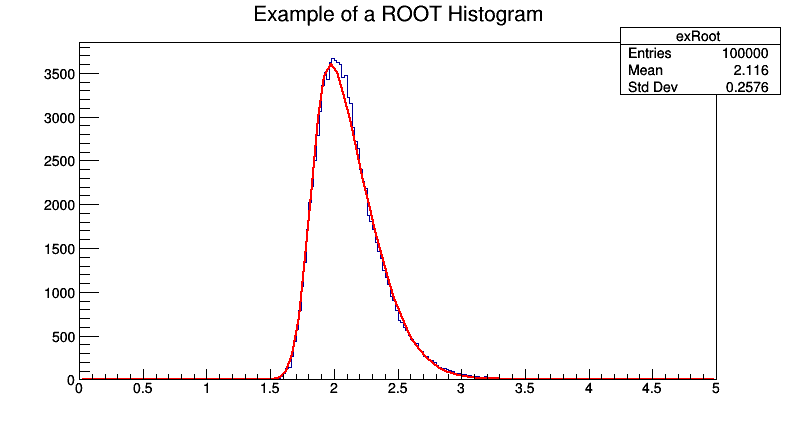

In [6]:
exRoot.Fit("SkewedVoigt", "", "", 0.0,5.0)
exRoot.Draw()
c1.Draw()

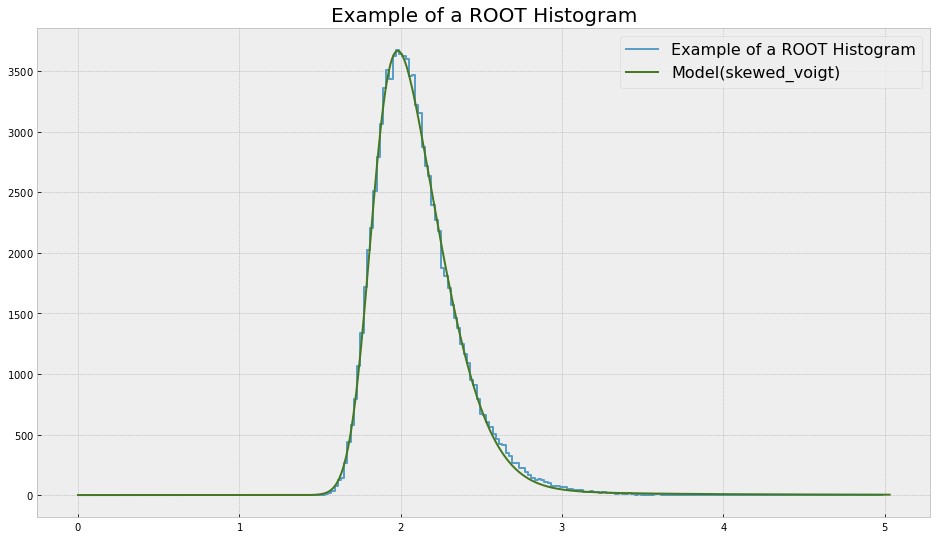

In [7]:
hist = exRoot.toScatter()
hist.histogram()
out = hist.fitSkewedVoigt(plots=False)
for i, k in enumerate(out.params):
    val = f.GetParameters()[i]
    out.params[k].set(value=val, vary=True if i != 0 else False)

out = hist.fitSkewedVoigt(params=out.params)
plt.show()

out